In [1]:
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import seaborn as sns

import scienceplots
#plt.style.use(['science', 'ieee', 'notebook'])

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/gits/sklearn-sid/Volve-Dataset/data/volve_compiled.pkl


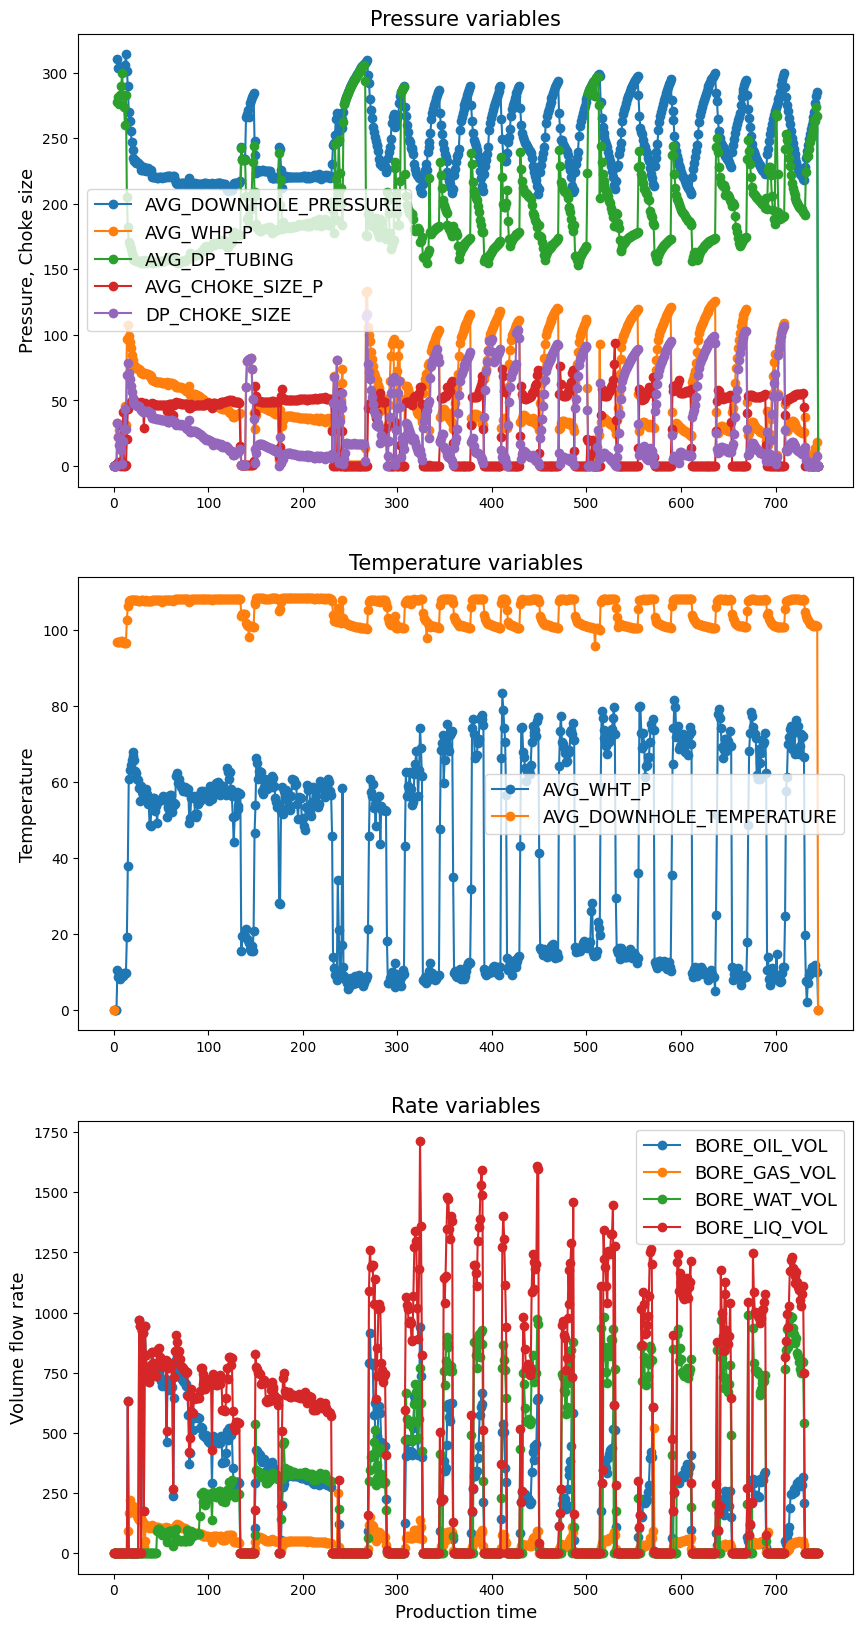

In [3]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        'BORE_OIL_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        #'BORE_WI_VOL',
        #'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        'BORE_OIL_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
        'BORE_LIQ_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(3,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[2].plot(time, data_case[var], '-o', label=var)
#for var in filt_vars_OUT:
#    ax[3].plot(time, data_case[var], '-o', label=var)
title_font = 15
label_font = 13
ax[0].set_title(f'Pressure variables', fontsize=title_font)
ax[1].set_title(f'Temperature variables', fontsize=title_font)
ax[2].set_title(f'Rate variables', fontsize=title_font)
ax[0].set_ylabel('Pressure, Choke size', fontsize=label_font)
ax[1].set_ylabel('Temperature', fontsize=label_font)
ax[2].set_ylabel('Volume flow rate', fontsize=label_font)
ax[2].set_xlabel('Production time', fontsize=label_font)
ax[0].legend(fontsize=label_font)
ax[1].legend(fontsize=label_font)
ax[2].legend(fontsize=label_font)

fig.savefig('data/data_example.pdf',  bbox_inches = "tight")

In [4]:
prefix = 'SISO.W1'
binary = os.path.join(os.getcwd(), 'outputs', 'test_runs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    X1_tr, y_tr, X1_te, y_te, results, order_progression = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/gits/sklearn-sid/Volve-Dataset/outputs/test_runs/SISO.W1_ml.pkl


In [5]:
model_pars = []
best_pars = []
yhats = []
lags = []
for index, row in pd.DataFrame(results).iloc[2:,:].iterrows():
    yhats.append([f"{row['MODEL']}.{prefix}",row['MODEL OBJ'].predict(X1_te, y_te),row['MODEL OBJ'].predict(X1_te, y_te, steps_ahead=1)])
    try:
        model_pars.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].estimator.cv_results_))
        best_pars.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].estimator.best_params_))
        lags.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].nX))
    except Exception as e: 
        print(e)


In [6]:
prefix = 'MISO.W1'
binary = os.path.join(os.getcwd(), 'outputs', 'test_runs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    X1_tr, y_tr, X1_te, y_te, results, order_progression = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/gits/sklearn-sid/Volve-Dataset/outputs/test_runs/MISO.W1_ml.pkl


In [7]:
for index, row in pd.DataFrame(results).iloc[2:,:].iterrows():
    yhats.append([f"{row['MODEL']}.{prefix}",row['MODEL OBJ'].predict(X1_te, y_te),row['MODEL OBJ'].predict(X1_te, y_te, steps_ahead=1)])
    try:
        model_pars.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].estimator.cv_results_))
        best_pars.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].estimator.best_params_))
        lags.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].nX))
    except Exception as e: 
        print(e)

In [8]:
cv_errors = {
    'MODEL' : [],
    'INPUTS': [],
    'SPLIT' : [],
    'R2 SCORE': [],
            }

mlp_data = {
    'INPUTS' : [],
    'R2 MEAN SCORE' : [],
    'R2 STD DEV' : []
    }

times = {
    'MODEL':[],
    'INPUTS': [],
    'TIME MEAN' :[],
    'TIME STD': []
}
for model, model_par in model_pars:
    if 'MLP' in model:
        r2_scores = model_par['mean_test_score'].tolist()
        r2_scores_std = model_par['std_test_score'].tolist()
        n_r2 = len(r2_scores)
        mlp_data['INPUTS'].extend([model.split('.')[1]]*n_r2)
        mlp_data['R2 MEAN SCORE'].extend(r2_scores)
        mlp_data['R2 STD DEV'].extend(r2_scores_std)
    best_model = np.where(model_par['rank_test_score'] == 1)[0]
    times['MODEL'].append(model.split('.')[0])
    times['INPUTS'].append(model.split('.')[1])
    times['TIME MEAN'].append(model_par['mean_fit_time'][best_model][0])
    times['TIME STD'].append(model_par['std_fit_time'][best_model][0])
    for key in model_par.keys():
        if 'split' in key and '_test_score' in key:
            cv_errors['MODEL'].append(model.split('.')[0])
            cv_errors['INPUTS'].append(model.split('.')[1])
            cv_errors['SPLIT'].append(int(key.split('_')[0][5:]))
            cv_errors['R2 SCORE'].append(model_par[key][best_model][0])
        elif 'MLP' in model and 'param_' in key:
            pname = key[6:]
            if not pname in mlp_data.keys():
                try:
                    mlp_data[pname] = model_par[key].tolist()
                except Exception:
                    mlp_data[pname] = model_par[key]
            else:
                try:
                    mlp_data[pname].extend(model_par[key].tolist())
                except Exception:
                    mlp_data[pname].extend(model_par[key])
            
            

cv_errors = pd.DataFrame(cv_errors)
mlp_data['hidden_layers'] = [len(x) for x in mlp_data['hidden_layer_sizes']]
mlp_data['total_hidden_units'] = [np.sum(x) for x in mlp_data['hidden_layer_sizes']]
mlp_data = pd.DataFrame(mlp_data)
mlp_data.drop(columns=['activation', 'max_iter', 'solver'], inplace=True)
display(mlp_data)

INPUTS  R2 MEAN SCORE  R2 STD DEV     alpha  batch_size  early_stopping   
0     SISO       0.702249    0.057943  0.030304         256           False  \
1     SISO       0.772532    0.055266  0.034329          32            True   
2     SISO       0.725963    0.064230  0.086851         128           False   
3     SISO       0.756539    0.074461  0.004190          32           False   
4     SISO       0.757736    0.063278  0.001361          32            True   
..     ...            ...         ...       ...         ...             ...   
195   MISO       0.695150    0.066496  0.348421          32           False   
196   MISO       0.742038    0.064623  0.000114          64           False   
197   MISO       0.776016    0.065690  0.053043          32           False   
198   MISO       0.734673    0.071726  0.023639         256           False   
199   MISO       0.765646    0.071471  0.043703          64           False   

    hidden_layer_sizes           tol  hidden_layers  total_hidden_units  
0    (80, 40, 40, 100)  3.019659e-03              4                 260  
1     (80, 80, 20, 20)  1.643129e-05              4                 200  
2    (20, 100, 40, 60)  2.306157e-06              4                 220  
3        (60, 40, 100)  1.917448e-06              3                 200  
4            (60, 100)  3.058823e-04              2                 160  
..                 ...           ...            ...                 ...  
195  (100, 60, 60, 20)  2.154966e-02              4                 240  
196   (20, 80, 60, 60)  1.092597e-06              4                 220  
197  (100, 60, 40, 80)  1.110901e-05              4                 280  
198   (80, 80, 60, 40)  8.299463e-07              4                 260  
199       (40, 80, 40)  1.633811e-05              3                 160  

[200 rows x 10 columns]

/tmp/ipykernel_27852/1556929069.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(),rotation=90)


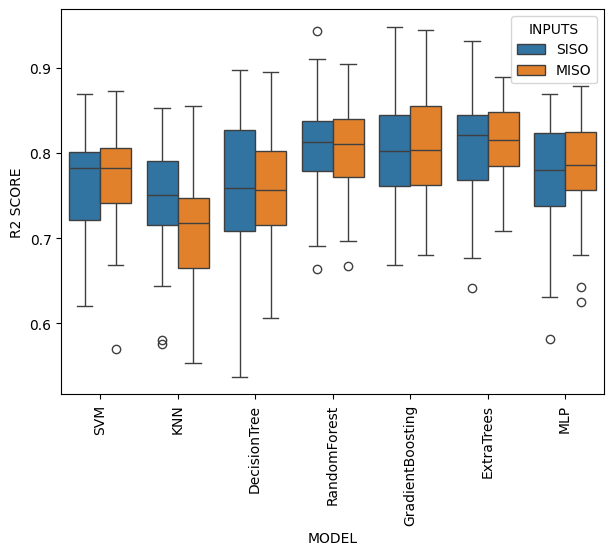

In [9]:
#plt.style.use(['science', 'ieee', 'notebook'])
cv_errors_filt = cv_errors[
    (cv_errors.MODEL == 'LinReg')|
    (cv_errors.MODEL == 'PolyReg')|
    (cv_errors.MODEL == 'MLP')
]
fig, axs = plt.subplots(1,1, figsize=(7,5))
sns.boxplot(data=cv_errors, x='MODEL', y='R2 SCORE', hue='INPUTS', ax=axs)
axs.set_xticklabels(axs.get_xticklabels(),rotation=90)
fig.savefig('./outputs/final_results/boxplot_cv.pdf', bbox_inches = "tight")

In [10]:
pd.DataFrame(times)

MODEL INPUTS  TIME MEAN  TIME STD
0                SVM   SISO   0.004583  0.001077
1                KNN   SISO   0.000491  0.000275
2       DecisionTree   SISO   0.001372  0.000282
3       RandomForest   SISO   0.156311  0.015630
4   GradientBoosting   SISO   0.817508  0.036176
5         ExtraTrees   SISO   0.093481  0.013280
6                MLP   SISO   0.432160  0.220667
7                SVM   MISO   0.005467  0.001166
8                KNN   MISO   0.000669  0.000197
9       DecisionTree   MISO   0.000785  0.000093
10      RandomForest   MISO   0.248601  0.015328
11  GradientBoosting   MISO   1.576604  0.068183
12        ExtraTrees   MISO   0.118844  0.012206
13               MLP   MISO   0.450073  0.173006

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


SVM.SISO.W1
R2 Train (OSA): 0.8131516984901832
R2 Test (OSA): 0.7694132959590332
R2 Full  (OSA): 0.7998602312992494
R2 Train (FS):  0.5727742018136717
R2 Test (FS):  0.6635978006669897
R2 Full  (FS):  0.607320595858757
RMSE Train (OSA): 0.11407026220970663
RMSE Test (OSA): 0.13964891321139739
RMSE Full  (OSA): 0.12232900808531075
RMSE Train (FS):  0.1724870908893285
RMSE Test (FS):  0.16867465970636183
RMSE Full  (FS):  0.17134909662916487
KNN.SISO.W1
R2 Train (OSA): 0.9985338112248625
R2 Test (OSA): 0.7128462497545175
R2 Full  (OSA): 0.9013306995723056
R2 Train (FS):  0.5415426663871148
R2 Test (FS):  0.48325926888436865
R2 Full  (FS):  0.5256160918233392
RMSE Train (OSA): 0.01010468565841741
RMSE Test (OSA): 0.15583954649532802
RMSE Full  (OSA): 0.08589221093643355
RMSE Train (FS):  0.17868056816725253
RMSE Test (FS):  0.20905317947653212
RMSE Full  (FS):  0.18833356694484388
DecisionTree.SISO.W1
R2 Train (OSA): 0.876747374236524
R2 Test (OSA): 0.7034965447001115
R2 Full  (OSA): 0.81

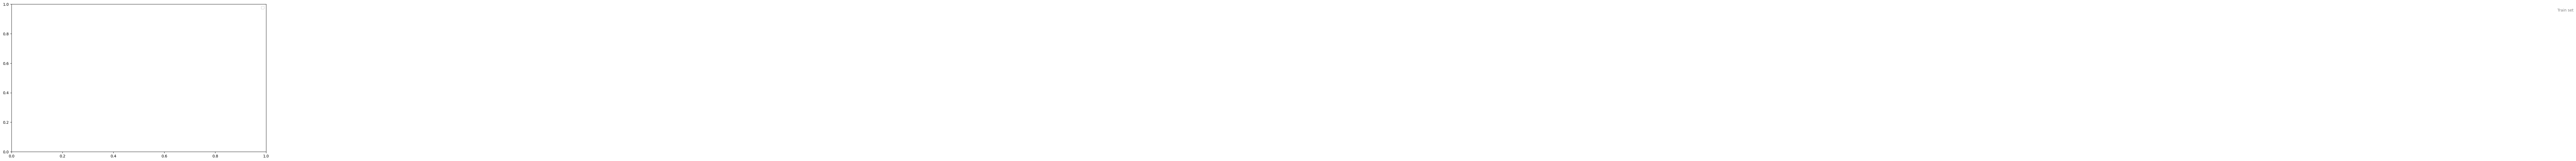

In [11]:
errors = {
    'MODEL':[],
    'INPUTS':[],
    'R2 OSA TRAIN':[],
    'R2 OSA TEST':[],
    'R2 OSA TOTAL':[],
    'R2 FS TRAIN':[],
    'R2 FS TEST':[],
    'R2 FS TOTAL':[],
    'RMSE OSA TRAIN':[],
    'RMSE OSA TEST':[],
    'RMSE OSA TOTAL':[],
    'RMSE FS TRAIN':[],
    'RMSE FS TEST':[],
    'RMSE FS TOTAL':[],
    }

fig, ax   = plt.subplots(1,1, figsize=(12,7))
for model, yhat, yhat_OSA in yhats:
    model_name = model.split('.')[0]
    model_input = model.split('.')[1]
    errors['MODEL'].append(model_name)
    errors['INPUTS'].append(model_input)
    #if not model_name in ['PolyReg', 'LinReg', 'MLP']: continue
    print(model)
    print('R2 Train (OSA):', r2_score(y_te.ravel()[:502], yhat_OSA.ravel()[:502]))
    errors['R2 OSA TRAIN'].append(r2_score(y_te.ravel()[:502], yhat_OSA.ravel()[:502]))
    print('R2 Test (OSA):', r2_score(y_te.ravel()[502:], yhat_OSA.ravel()[502:]))
    errors['R2 OSA TEST'].append(r2_score(y_te.ravel()[502:], yhat_OSA.ravel()[502:]))
    print('R2 Full  (OSA):', r2_score(y_te.ravel(), yhat_OSA.ravel()))
    errors['R2 OSA TOTAL'].append(r2_score(y_te.ravel(), yhat_OSA.ravel()))
    print('R2 Train (FS): ', r2_score(y_te.ravel()[:502], yhat.ravel()[:502]))
    errors['R2 FS TRAIN'].append(r2_score(y_te.ravel()[:502], yhat.ravel()[:502]))
    print('R2 Test (FS): ', r2_score(y_te.ravel()[502:], yhat.ravel()[502:]))
    errors['R2 FS TEST'].append(r2_score(y_te.ravel()[502:], yhat.ravel()[502:]))
    print('R2 Full  (FS): ', r2_score(y_te.ravel(), yhat.ravel()))
    errors['R2 FS TOTAL'].append(r2_score(y_te.ravel()[:], yhat.ravel()[:]))
    print('RMSE Train (OSA):', mean_squared_error(y_te.ravel()[:502], yhat_OSA.ravel()[:502])**0.5)
    errors['RMSE OSA TRAIN'].append(mean_squared_error(y_te.ravel()[:502], yhat_OSA.ravel()[:502])**0.5)
    print('RMSE Test (OSA):', mean_squared_error(y_te.ravel()[502:], yhat_OSA.ravel()[502:])**0.5)
    errors['RMSE OSA TEST'].append(mean_squared_error(y_te.ravel()[502:], yhat_OSA.ravel()[502:])**0.5)
    print('RMSE Full  (OSA):', mean_squared_error(y_te.ravel(), yhat_OSA.ravel())**0.5)
    errors['RMSE OSA TOTAL'].append(mean_squared_error(y_te.ravel()[:], yhat_OSA.ravel()[:])**0.5)
    print('RMSE Train (FS): ', mean_squared_error(y_te.ravel()[:502], yhat.ravel()[:502])**0.5)
    errors['RMSE FS TRAIN'].append(mean_squared_error(y_te.ravel()[:502], yhat.ravel()[:502])**0.5)
    print('RMSE Test (FS): ', mean_squared_error(y_te.ravel()[502:], yhat.ravel()[502:])**0.5)
    errors['RMSE FS TEST'].append(mean_squared_error(y_te.ravel()[502:], yhat.ravel()[502:])**0.5)
    print('RMSE Full  (FS): ', mean_squared_error(y_te.ravel(), yhat.ravel())**0.5)
    errors['RMSE FS TOTAL'].append(mean_squared_error(y_te.ravel()[:], yhat.ravel()[:])**0.5)
    if not 'LinReg' in model: continue
    ax.plot(yhat, label=' - '.join(model.split('.')[:-1]))
    ax.plot(y_te, 'k--', label='Real data')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Normalized Output (Liquid Rate)')
    ax.set_title('Model comparison with real data (Free run simulation)')
    ax.fill_between(np.arange(0, len(yhat)), 0, 1, where = np.arange(0, len(yhat))<=502,
                facecolor ='grey', alpha = 0.25)
ax.legend()
ax.set_xlim(0,None)
ax.set_ylim(0,1)
ax.text(10, 0.95, 'Train set', color='grey')
fig.savefig(f'./outputs/final_results/best_model.pdf')

In [12]:
results_df = pd.concat([pd.DataFrame(errors), pd.DataFrame(times).iloc[:,2:]],axis='columns').sort_values('R2 FS TOTAL', ascending=False).reset_index().sort_values('index').reset_index()
results_df['BEST LAG'] = np.array([lag[-1] for lag in lags])
results_df['level_0'] += 1
results_df = results_df[['MODEL', 'INPUTS', 'BEST LAG', 'R2 OSA TRAIN', 'R2 FS TRAIN', 'RMSE OSA TRAIN', 'RMSE FS TRAIN', 'R2 OSA TOTAL', 'R2 FS TOTAL', 'RMSE OSA TOTAL', 'RMSE FS TOTAL', 'TIME MEAN', 'level_0']].round(3)

In [13]:
print(results_df.to_latex(index=False,))

\begin{tabular}{llrrrrrrrrrrr}
\toprule
MODEL & INPUTS & BEST LAG & R2 OSA TRAIN & R2 FS TRAIN & RMSE OSA TRAIN & RMSE FS TRAIN & R2 OSA TOTAL & R2 FS TOTAL & RMSE OSA TOTAL & RMSE FS TOTAL & TIME MEAN & level_0 \\
\midrule
SVM & SISO & 20 & 0.813000 & 0.573000 & 0.114000 & 0.172000 & 0.800000 & 0.607000 & 0.122000 & 0.171000 & 0.005000 & 13 \\
KNN & SISO & 12 & 0.999000 & 0.542000 & 0.010000 & 0.179000 & 0.901000 & 0.526000 & 0.086000 & 0.188000 & 0.000000 & 14 \\
DecisionTree & SISO & 13 & 0.877000 & 0.652000 & 0.093000 & 0.156000 & 0.819000 & 0.614000 & 0.116000 & 0.170000 & 0.001000 & 12 \\
RandomForest & SISO & 15 & 0.917000 & 0.632000 & 0.076000 & 0.160000 & 0.874000 & 0.643000 & 0.097000 & 0.163000 & 0.156000 & 7 \\
GradientBoosting & SISO & 15 & 0.964000 & 0.650000 & 0.050000 & 0.156000 & 0.896000 & 0.632000 & 0.088000 & 0.166000 & 0.818000 & 10 \\
ExtraTrees & SISO & 14 & 0.949000 & 0.636000 & 0.059000 & 0.159000 & 0.888000 & 0.621000 & 0.092000 & 0.168000 & 0.093000 & 11 \\
M

In [14]:
import json
parameters = {
    'Estimator':[],
    'INPUTS':[],
    'Parameter name':[],
    'Parameter value':[],
    }
for model, par in best_pars:
    count = 0
    plist = list(par.keys())
    plist.sort()
    for parname in plist:
        if count == 0:
            parameters['Estimator'].append(model.split('.')[0])
            count = 1
        else:
            parameters['Estimator'].append("")
        parameters['INPUTS'].append(model.split('.')[1])
        parameters['Parameter name'].append(parname)
        parameters['Parameter value'].append(par[parname])

parameters = pd.DataFrame(parameters)
parameters_final = parameters[parameters['INPUTS'] == 'SISO']
parameters_final.loc[:,'MISO'] = parameters[parameters['INPUTS'] == 'MISO']['Parameter value'].values
parameters = parameters_final[['Estimator', 'Parameter name', 'Parameter value', 'MISO']]


/tmp/ipykernel_27852/453070497.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_final.loc[:,'MISO'] = parameters[parameters['INPUTS'] == 'MISO']['Parameter value'].values


In [15]:
print(pd.DataFrame(parameters).to_latex(index=False))

\begin{tabular}{llll}
\toprule
Estimator & Parameter name & Parameter value & MISO \\
\midrule
SVM & C & 5.275248 & 11.272576 \\
 & degree & 3 & 5 \\
 & gamma & 0.013454 & 0.005074 \\
 & kernel & rbf & rbf \\
KNN & n_neighbors & 6 & 4 \\
 & weights & distance & distance \\
DecisionTree & max_depth & 8 & 10 \\
 & max_features & 0.227019 & 0.199842 \\
 & max_leaf_nodes & 81 & 82 \\
 & min_samples_leaf & 6 & 18 \\
 & min_samples_split & 12 & 8 \\
 & splitter & best & random \\
RandomForest & max_depth & 7 & 11 \\
 & max_features & 0.378743 & 0.239132 \\
 & max_leaf_nodes & 114 & 102 \\
 & min_samples_leaf & 4 & 4 \\
 & min_samples_split & 9 & 9 \\
 & n_estimators & 75 & 52 \\
GradientBoosting & criterion & friedman_mse & friedman_mse \\
 & learning_rate & 0.085541 & 0.085541 \\
 & loss & huber & huber \\
 & max_depth & 11 & 11 \\
 & max_features & 0.537705 & 0.537705 \\
 & max_leaf_nodes & 28 & 28 \\
 & min_samples_leaf & 8 & 8 \\
 & min_samples_split & 3 & 3 \\
 & n_estimators & 77 & 77 

In [16]:
plt.style.use(['science', 'ieee', 'notebook'])
plot_model = ['GradientBoosting', 'ExtraTrees', 'RandomForest', 'MLP']

fig, axs   = plt.subplots(2,1, figsize=(20,16))
for model, yhat, yhat_OSA in yhats:
    model_name = model.split('.')[0]
    #if not model_name in ['PolyReg', 'LinReg', 'MLP']: continue
    if not model_name in plot_model: continue
    if 'MISO' in model:
        ind = 1
    else:
        ind = 0
    axs[ind].plot(yhat, label=', '.join(model.split('.')[:-1]))
    print(model)
    print('RMSE Train (OSA):', mean_squared_error(y_te.ravel()[:502], yhat_OSA.ravel()[:502])**0.5)
    print('RMSE Full  (OSA):', mean_squared_error(y_te.ravel(), yhat_OSA.ravel())**0.5)
    print('RMSE Train (FS): ', mean_squared_error(y_te.ravel()[:502], yhat.ravel()[:502])**0.5)
    print('RMSE Full  (FS): ', mean_squared_error(y_te.ravel(), yhat.ravel())**0.5)
axs[0].set_title('Model comparison with real data (Free run simulation, SISO)', fontsize=title_font)
axs[1].set_title('Model comparison with real data (Free run simulation, MISO)', fontsize=title_font)
for ax in axs:
    ax.plot(y_te, 'o', label='Real data')
    ax.set_xlabel('Time (days)', fontsize=label_font)
    ax.set_ylabel('Normalized Output (Liquid Rate)', fontsize=label_font)
    ax.fill_between(np.arange(0, len(yhat)), 0, 1, where = np.arange(0, len(yhat))<=502,
                facecolor ='grey', alpha = 0.25)
    ax.legend(fontsize=label_font)
    ax.set_xlim(0,None)
    ax.set_ylim(0,1)
    ax.text(10, 0.05, 'Train set', color='grey', fontsize=title_font)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#fig.savefig(f'./outputs/{plot_model}_comparison_big.pdf')
fig.savefig(f'./outputs/final_results/global_comparison_big.pdf')

RandomForest.SISO.W1
RMSE Train (OSA): 0.07610895394005684
RMSE Full  (OSA): 0.09701557228516922
RMSE Train (FS):  0.16010171430358774
RMSE Full  (FS):  0.16344717767347822
GradientBoosting.SISO.W1
RMSE Train (OSA): 0.050098194458102784
RMSE Full  (OSA): 0.08823767521825417
RMSE Train (FS):  0.15615473818107767
RMSE Full  (FS):  0.16590964590074805
ExtraTrees.SISO.W1
RMSE Train (OSA): 0.059395037409578896
RMSE Full  (OSA): 0.09163284136142677
RMSE Train (FS):  0.15930188193222056
RMSE Full  (FS):  0.16840249561098397
MLP.SISO.W1
RMSE Train (OSA): 0.11144494718780414
RMSE Full  (OSA): 0.12340840871546883
RMSE Train (FS):  0.1627501819958334
RMSE Full  (FS):  0.1633585978672286
RandomForest.MISO.W1
RMSE Train (OSA): 0.06824542606866085
RMSE Full  (OSA): 0.09159513709068438
RMSE Train (FS):  0.13518597887573425
RMSE Full  (FS):  0.14627801257612066
GradientBoosting.MISO.W1
RMSE Train (OSA): 0.04178326812832681
RMSE Full  (OSA): 0.08032268963798281
RMSE Train (FS):  0.1282191824166429
RMSE